In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy.stats import norm, lognorm, skewnorm, expon
from tqdm.notebook import tqdm

In [2]:
def matrix_maker(cols, rows, disribution='normal',mean=1,std=1):
    if disribution == 'normal':
        out = np.zeros((cols,rows))
        for i in range(cols):
            for j in range(rows):
                out[i][j] = np.random.normal(loc=mean,scale=std,size=None)
    if disribution == 'None':
        out = np.ones((cols,rows)) * mean
        
    return out

In [3]:
def crossbar_VTEAM(Ron_mat, Roff_mat, t, v_mat, w_mat, koff, kon, aoff, aon, 
                   voff_mat, von_mat, woff_mat, won_mat, p_mat, j_mat, col_res, row_res, foff='johleker', fon='johleker'):
    
    def prodromakis(x,p,j):
        dum=(x-0.5)**2
        dum1=(dum+0.75)**p
        return(j*(1-dum1))
    def why(x,d):
        return((x*(d-x))/(d**2))
    def johleker(x,p):
        return(1-(((2*x)-1)**(2*p)))
    
    def dw(v,koff,kon,aoff,aon,voff,von,woff,won,w,p,j,dt,foff=foff, fon=fon):

        x = w / (woff-won) 
        if 0<voff<v:
            dum = koff*(((v/voff)-1)**aoff)
            if foff == 'prodromakis':
                func = prodromakis(x,p,j)
            if foff =='test':
                func = why(w,woff)
            if foff == 'johleker':
                func = johleker(x,p)
            return(dum*func*dt)


        if von<v<voff:
            return(0)

        if v<von<0:
            dum = kon*(((v/von)-1)**aon)
            if fon == 'prodromakis':
                func = prodromakis(x,p,j)
            if fon == 'test':
                func = why(w,woff)
            if fon == 'johleker':
                func = johleker(x,p)  

            return(dum*func*dt)

        else: 
            return(0)
        
        
        
    def Linear_relation(Ron, Roff, won, woff, w):
        dum = w-won
        dum1 = (Roff - Ron) * dum * (1/(woff-won))
        dum2 = Ron + dum1
        return (dum2**(-1))

    
    cols = np.shape(Ron_mat)[0] #finds the number of columns to go through 
    rows = np.shape(Ron_mat)[1] #finds the number of rows to go through  
    
    out_mat = np.empty_like(v_mat).transpose()
    res = []
    X_out= w_mat
    for k in range(len(t)):
        if k == 0:
            dt = 0
        else:
            dt = t[k] - t[k-1]
            
        res_mat = np.empty((cols,rows))
           
        for i in range(cols):
            for j in range(rows):
                res_mat[i,j] = ( Linear_relation(Ron_mat[i,j], Roff_mat[i,j], won_mat[i,j], woff_mat[i,j], w_mat[i,j]) )
        
        X_out=np.append(X_out,w_mat)
        
        
             #this part needs changing
        cur_matrix = np.empty_like(out_mat[k])
        for i in range(cols):
            row_current = 0
            for j in range(rows):
                dum = (row_res*(rows-j)) + (col_res*i) + (res_mat[i,j]**(-1))
                #print(dum)
                row_current += (1/dum)*v_mat[j,k]
                
            cur_matrix[j] = row_current
        #print('-------------------')
        out_mat[k] = cur_matrix
                
        #out_mat[k] = np.dot(v_mat[:,k],res_mat)
        
        
        
        
        
        res.append(res_mat)
        
        
        for i in range(cols):
            for j in range(rows):
                update = dw(v_mat[j,k], koff, kon, aoff, aon, voff_mat[i,j], von_mat[i,j], woff_mat[i,j], won_mat[i,j], w_mat[i,j], p_mat[i,j], j_mat[i,j],dt )
                
                w_mat[i,j] = w_mat[i,j] + update
        
    res = np.array(res)
    X_out = X_out[(cols*rows):].reshape(len(t),cols,rows)
    #print(X_out)
    return out_mat, res, X_out

In [4]:
def make_plots(I_out, res, w_out, t, v_mat, won_mat, woff_mat):
    
    plt.figure(figsize=(20,10))
    ax0 = plt.subplot(2,2,1)
    ax1 = plt.subplot(2,2,2)
    ax2 = plt.subplot(2,2,3)
    ax3 = plt.subplot(2,2,4)
   
    ax0.set_title('Resistance for row 1 column 1')
    ax0.plot(t,res[:,0,0],color='black')
    ax0.set_xlabel('Time (s)')
    ax0.set_ylabel('Resistance (\u03A9)')
    ax0.grid()
    
    ax1.set_title('Resistance for row 1 column 2')
    ax1.plot(t,res[:,0,1],color='black')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Resistance (\u03A9)')
    ax1.grid()
    
    ax2.set_title('Resistance for row 2 column 1')
    ax2.plot(t,res[:,1,0],color='black')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Resistance (\u03A9)')
    ax2.grid()
    
    ax3.set_title('Resistance for row 2 column 2')
    ax3.plot(t,res[:,1,1],color='black')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Resistance (\u03A9)')
    ax3.grid()
    plt.show()
    
    #----------------------------------------------------
    
    plt.figure(figsize=(20,10))
    ax0 = plt.subplot(2,2,1)
    ax1 = plt.subplot(2,2,2)
    ax2 = plt.subplot(2,2,3)
    ax3 = plt.subplot(2,2,4)
   
    ax0.set_title('Boundary Position for row 1 column 1')
    ax0.plot(t,w_out[:,0,0],color='black')
    ax0.hlines(won_mat[0,0],min(t),max(t),color='red',label='Minimum W')
    ax0.hlines(woff_mat[0,0],min(t),max(t),color='red',label='Maximum W')
    ax0.set_xlabel('Time (s)')
    ax0.set_ylabel('Boundary Position (m)')
    ax0.grid()
    ax0.legend()
    
    ax1.set_title('Boundary Position for row 1 column 2')
    ax1.plot(t,w_out[:,0,1],color='black')
    ax1.hlines(won_mat[0,1],min(t),max(t),color='red',label='Minimum W')
    ax1.hlines(woff_mat[0,1],min(t),max(t),color='red',label='Maximum W')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Boundary Position (m)')
    ax1.grid()
    ax1.legend()
    
    ax2.set_title('Boundary Position for row 2 column 1')
    ax2.plot(t,w_out[:,1,0],color='black')
    ax2.hlines(won_mat[1,0],min(t),max(t),color='red',label='Minimum W')
    ax2.hlines(woff_mat[1,0],min(t),max(t),color='red',label='Maximum W')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Boundary Position (m)')
    ax2.grid()
    ax2.legend()
    
    ax3.set_title('Boundary Position for row 2 column 2')
    ax3.plot(t,w_out[:,1,1],color='black')
    ax3.hlines(won_mat[1,1],min(t),max(t),color='red',label='Minimum W')
    ax3.hlines(woff_mat[1,1],min(t),max(t),color='red',label='Maximum W')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Boundary Position (m)')
    ax3.grid()
    ax3.legend()
    plt.show()
    
    
    
    
    #----------------------------------------------------
    
    plt.figure(figsize=(20,10))
    ax0 = plt.subplot(2,2,1)
    ax1 = plt.subplot(2,2,2)
    ax2 = plt.subplot(2,2,3)
    ax3 = plt.subplot(2,2,4)
    
    ax0.plot(t,v_mat[0],color='black')
    ax0.set_title('Input voltage row 1')
    ax0.set_xlabel('Time (s)')
    ax0.set_ylabel('Voltage (V)')
    ax0.grid()
    
    ax1.plot(t,v_mat[1],color='black')
    ax1.set_title('Input voltage row 2')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.grid()
    
    ax2.plot(t,I_out[:,0], color='black')
    ax2.set_title('Output Current Column 1')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Current (A)')
    ax2.grid()
    
    ax3.plot(t,I_out[:,1], color='black')
    ax3.set_title('Output Current Column 2')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Current (A)')
    ax3.grid()
    
    plt.show()

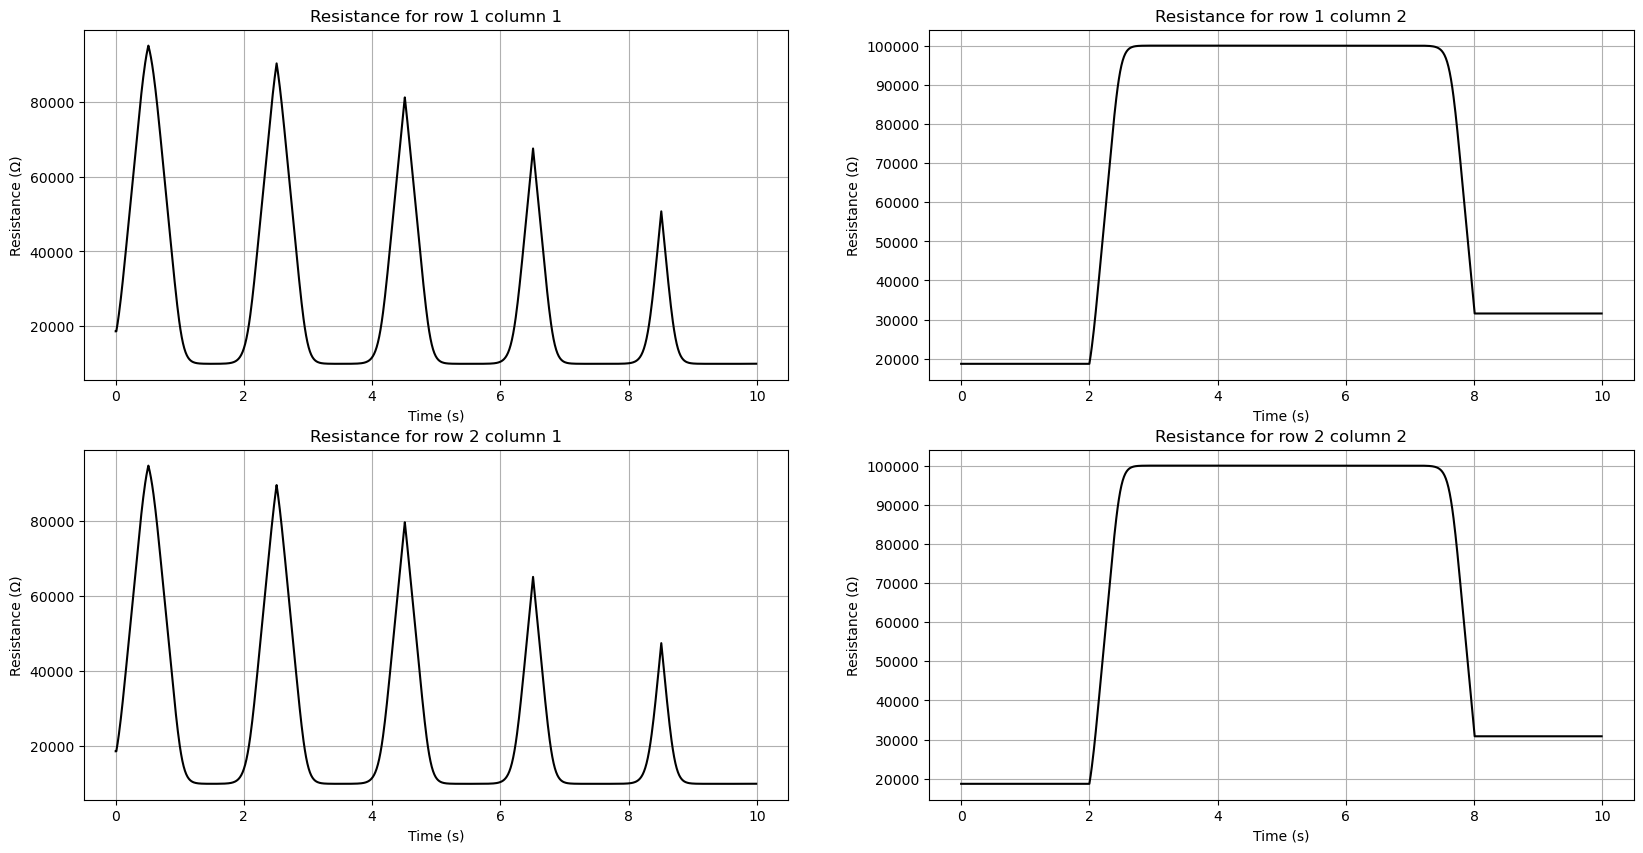

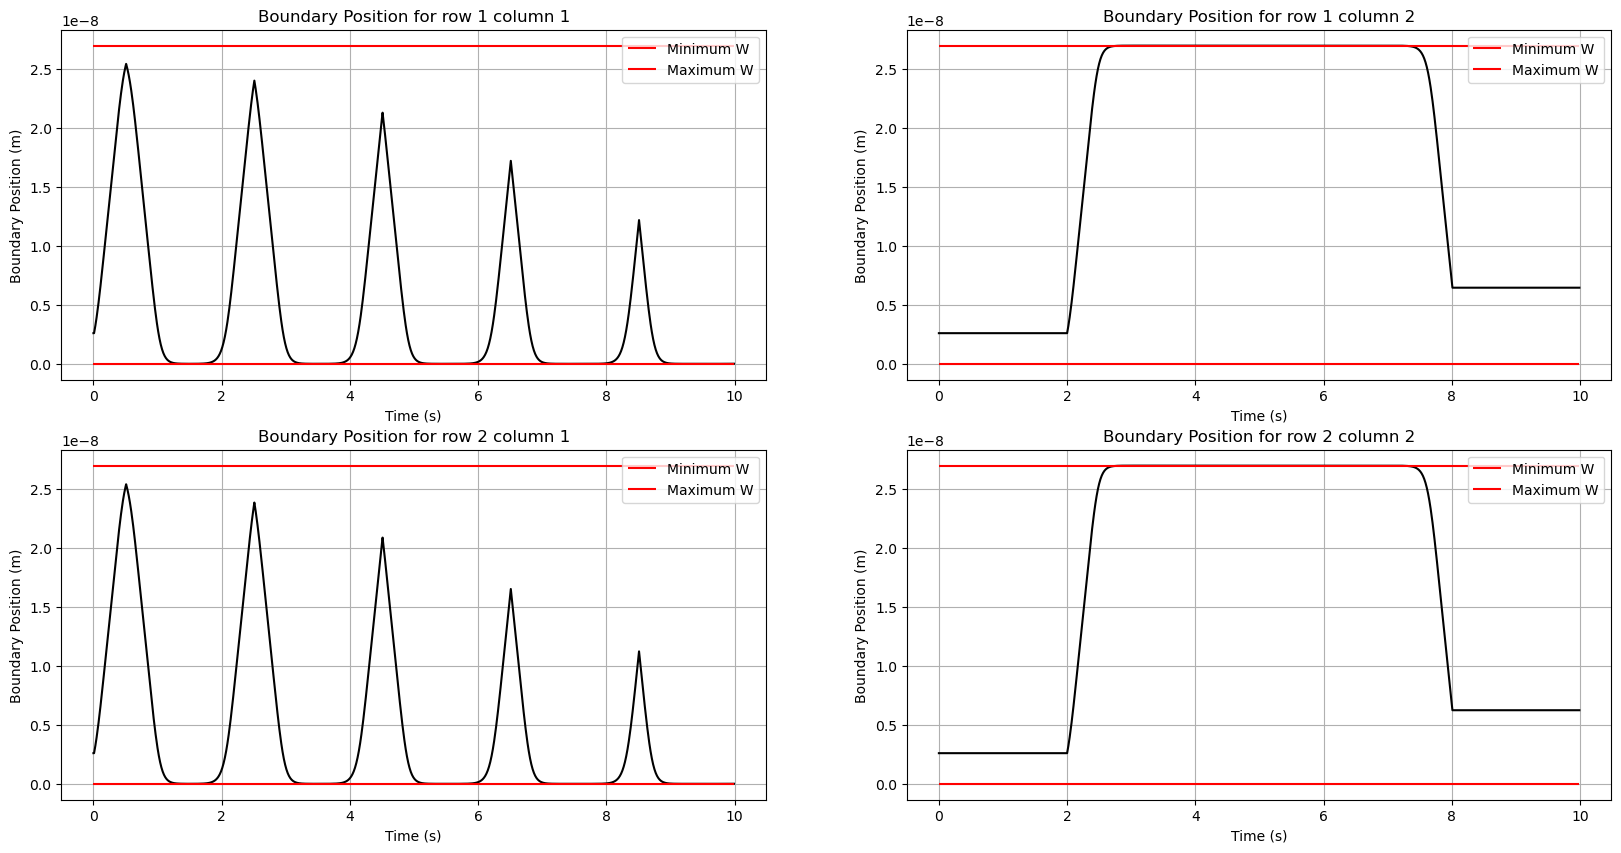

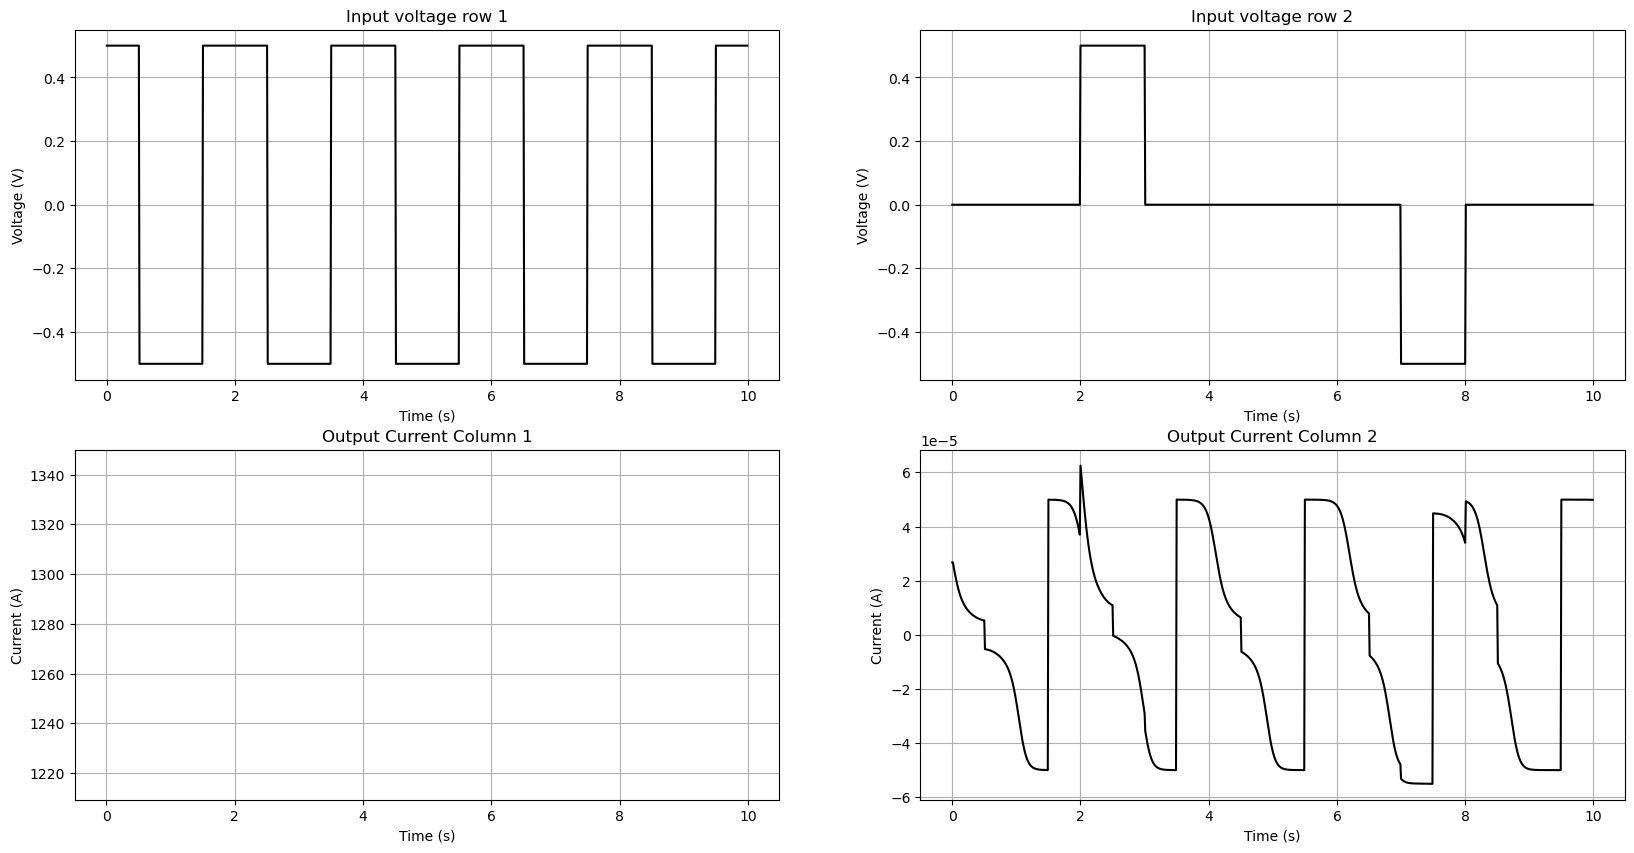

In [6]:
rows = 2
cols = 2
t = np.arange(0,10,0.01)
v01 = 0.5
v02 = 0.5
f1 = 1
f2 = 3
v1 = v01*np.sin(math.pi*2*f1*t)
v1 = np.zeros_like(t)
row_res = 1
col_res = 10
for i in range(len(t)):
    if round(t[i],0) %2 == 0:
        v1[i] = v01
    else:
        v1[i] = -v01

v2 = np.zeros_like(t)
for i in range(len(t)):
    if 2 <= t[i] <=3 :
        v2[i] = v02
    elif 7<= t[i] <=8:
        v2[i] = -v02
    else:
        v2[i] = 0
        
#v2 = v02*np.sin(math.pi*2*f2*t)
v_mat = np.empty((rows,len(t)))
v_mat[0],v_mat[1] = v1, v2

w = 2.6e-9
w_mat = matrix_maker(cols, rows, disribution='None',mean=w,)

won = 0
won_mat = matrix_maker(cols, rows, disribution='None',mean=won)

woff = 27e-9
woff_mat = matrix_maker(cols, rows, disribution='None',mean=woff)

koff = 3.3e-9
kon = -3.3e-9
aoff = 2
aon = 2

voff = 0.1
voff_std = 0.0001
voff_mat = matrix_maker(cols, rows, disribution='normal',mean=voff, std=voff_std)

von = -0.1
von_std = 0.0001
von_mat = matrix_maker(cols, rows, disribution='normal',mean=von, std=von_std)

roff = 100e3
roff_std = 0.1e3
Roff_mat = matrix_maker(cols, rows, disribution='normal',mean=roff, std=roff_std)

ron = 10e3
ron_std = 0.001e3
Ron_mat = matrix_maker(cols, rows, disribution='normal',mean=ron, std=ron_std)

p = 2
p_mat = matrix_maker(cols, rows, disribution='None',mean=p)

j = 4
j_mat = matrix_maker(cols, rows, disribution='None',mean=j)


I_out, res, w_out = crossbar_VTEAM(Ron_mat, Roff_mat, t, v_mat, w_mat, koff, kon, aoff, aon, 
                   voff_mat, von_mat, woff_mat, won_mat, p_mat, j_mat, col_res, row_res)

make_plots(I_out, 1/res, w_out, t, v_mat, won_mat, woff_mat)

In [ ]:
I_out[:,0]